In [47]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Why do I get weird behavior for the KL of the joint model ? 
Answer: because I had not normalized my formula properly.

In [48]:
results_dir = 'results'
file ='asyminter_asyminit_parameter_sweep_cause_k=10.pkl'
with open(os.path.join(results_dir, file), 'rb') as fin:
    results = pickle.load(fin)

In [49]:
for e in results:
    print(e['lr'])
    if e['lr']==3:
        break

0.03
0.1
0.3
1
3


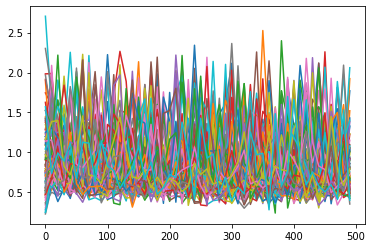

In [50]:
plt.plot(e['steps'], e['kl_joint'])
pass

Why does the geometric model seem super hard to optimize ? Investigate the property of this mean of logits.

In [51]:
from categorical.distances1 import sample_joint
from categorical.utils import entropy, kullback_leibler

In [52]:
k = 50
causal = sample_joint(k=k, n=100,concentration=1,symmetric=False)

In [53]:
geometric = causal.intervention(on='geometric')
weigthedgeo = causal.intervention(on='weightedgeo')

In [54]:
uniform = np.ones(k)/k
for marg in [
    causal.marginal,
    causal.reverse().marginal,
    geometric.reverse().marginal,
    weigthedgeo.reverse().marginal
]:
    hh = np.log(kullback_leibler(uniform, marg))
    print(hh.mean(),hh.std())


-0.5699041057407029 0.20749136412834057
-0.5613339687043495 0.20099114476649188
2.3588431069349327 0.2013970492868168
2.704330807866416 0.17674716585073963


The effect marginal is closer from uniform, and the geometric intervention is even closer.
On contrary the weighted geometic intervention is less close from the uniform.
The difficulty of optimizing for geometric intervention might be due to this uniformity. Converging to the center of the simplex is more difficult than converging to one of the sides which is effectively lower dimensional. Except that the KL explodes in these situations. This may also explain why the expected KL is 0.5 after geometric intervention vs 1 after other interventions. 

# What is the effect marginal like for different initializations ?

In [68]:
from categorical.distances1 import sample_joint, CategoricalStatic

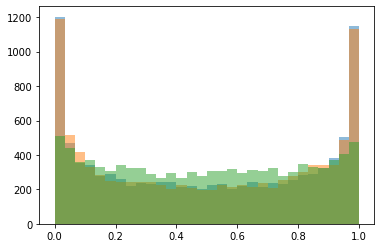

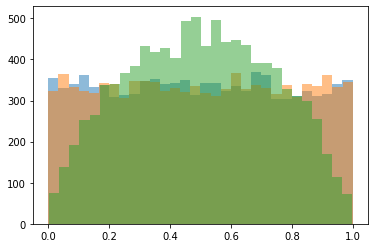

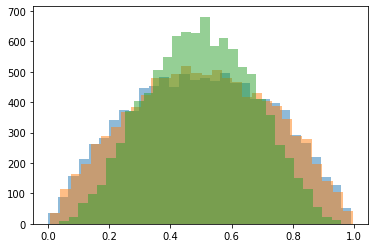

In [84]:
n=10000
k=2
for concentration in [.5,1,2]:
    plt.figure()
    for sym in [True, False]:
        p = sample_joint(k, n, concentration, symmetric=sym)
        q = p.reverse().marginal[:,0]
        plt.hist(q, bins=30,alpha=.5)

    pa = np.random.dirichlet(concentration * np.ones(k), size=n)
    pba = np.random.dirichlet(concentration * np.ones(k), size=[n, k])
    p = CategoricalStatic(pa, pba)
    q = p.reverse().marginal[:,0]
    plt.hist(q,bins=30,alpha=.5)
    plt.show()
    pass

# Analysis of chalupka with the modified sampling rule
The log likelihood ratio is now written

$$\sqrt{R} = \frac{(d+f)(1 - d - f)}{(d+e)(1 -d -e)}$$

In [196]:
def loglikelihoodratio(d,e,f):
    px1 = d+e
    varx = px1*(1-px1)
    py1 = d+f
    vary = py1 *(1-py1)
    return np.where(d+e+f >1, np.nan, np.log(vary) - np.log(varx))

def causal_likelihood(d,e,f):
    px1 = d+e
    varx = px1*(1-px1)
    g = 1- d - e -f
    return np.where(g<0, np.nan, .5*sum([np.log(i) for i in [d,e,f,g]]) - 2*np.log(varx))

In [197]:
xx = np.linspace(0.01,.99,20)
d,e,f = np.meshgrid(xx,xx,xx,indexing='ij')

In [202]:
r = loglikelihoodratio(d,e,f)[:-2]
# r = causal_likelihood(d,e,f)

/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [203]:
print(np.isnan(r).sum(), np.isinf(r).sum())

5871 0


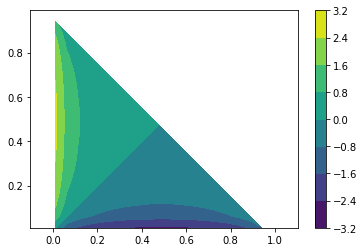

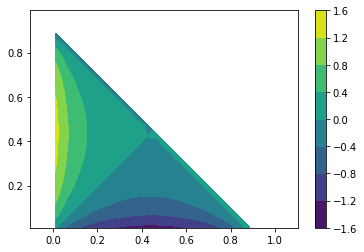

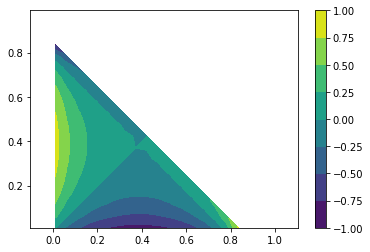

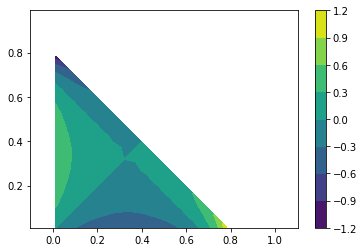

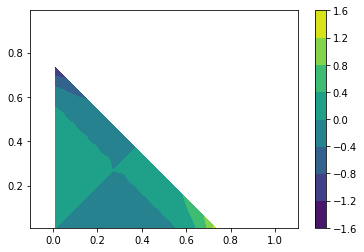

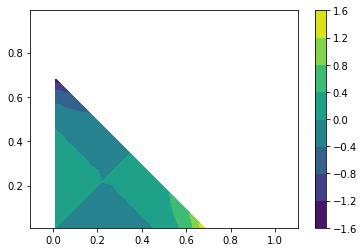

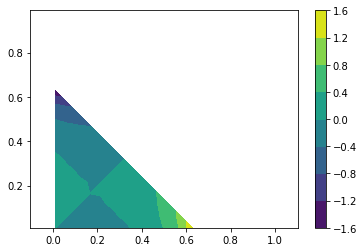

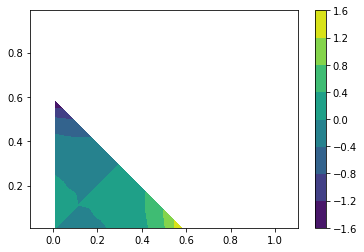

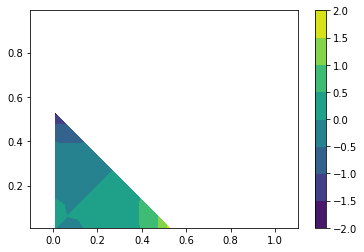

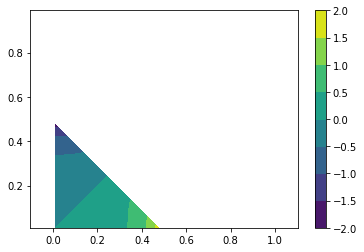

In [204]:
for i in range(min(r.shape[0],10)):
    plt.figure()
    plt.contourf(e[i], f[i], r[i], cmap='viridis')
    plt.axis('equal')
    plt.colorbar()
    

The classifier i got is the same as with their other assumption on the meta-prior. Now let's estimate the error rate of this likelihood ratio method under my hypothesis. Under their hypothesis, it was 0.4. I am basically estimating the overlap of distributions.

In [195]:
n = 100000
for conditional_prior in [(1,1),(.5,.5)]:
    a = np.random.beta(1,1, size=n)
    b = np.random.beta(*conditional_prior, size=n)
    c = np.random.beta(*conditional_prior, size=n)
    d, e, f = a*b, a*(1-b), (1-a)*c
    print((loglikelihoodratio(d,e,f)<0).mean(), np.mean(np.random.uniform(size=n)>.5))

0.38904 0.4992
0.49921 0.49893


This is no better than chance !! That is a harcore result. It should at least be slightly better. It means that both directions yield almost identical distributions in this framework. But the likelihood ratio seems to testify that both distributions are indeed different. Another meaning is that I got the calculation of the likelihood formula wrong at some point.That is the opnly reasonable explanation for the true likelihood ratio to give the same accuracy as chance.

I need to ask somone (eg reza) to review my result.

## Softargmax(loggamma vs gaussian)
Problem: the loggamma from scipy samples by explicitly taking the log of the gamma variable from the same scipy. It means that it's not numerically stable for low values of the shape parameter. I need to understand the behvaior of the loggamma distribution based on the shape parameter.

In [323]:
from categorical.utils import logit2proba
from scipy import stats

In [324]:
k=10
logitsgamma = stats.loggamma.rvs(c=1/k, size=(10,k))
pgamma = logit2proba(logitsgamma)
#no simple way to check whether this is the dirichlet I want
pgamma[0]

array([6.28e-15, 6.65e-01, 1.00e-03, 1.87e-03, 1.83e-02, 2.02e-01,
       1.76e-07, 3.09e-05, 6.13e-04, 1.11e-01])

law 0.01 	 mean -100.56 	 var 10001.62 	 #1f77b4
law 0.02 	 mean -50.54 	 var 2501.60 	 #ff7f0e
law 0.03 	 mean -33.86 	 var 1112.69 	 #2ca02c


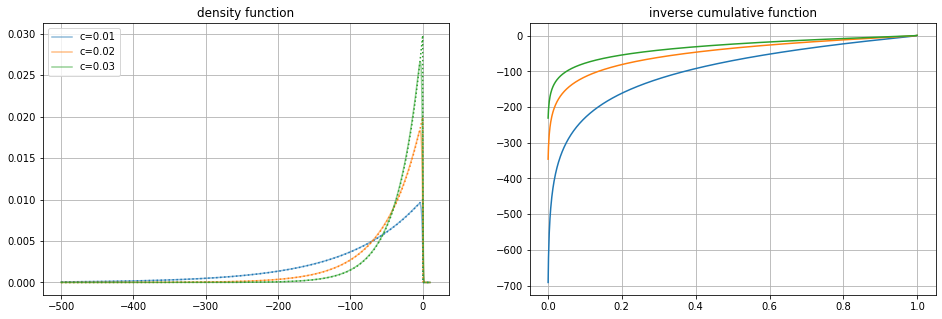

In [334]:
xx = np.linspace(-500, 10, 1000)
xx2 = np.linspace(0, 1, 1000)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
for k in range(1,4,1):
    c = k/100
    law = stats.loggamma(c)
    m = law.mean()
    v = law.var()
    # approx = stats.norm(m,np.sqrt(v))
    approx = stats.expon(scale=1/c)
    color = next(ax1._get_lines.prop_cycler)['color']
    print(f'law {c:.2f} \t mean {m:.2f} \t var {v:.2f} \t {color}')
    ax1.plot(xx, law.pdf(xx), color=color, label=f'c={c:.2f}', alpha=.5)
    ax1.plot(xx, approx.pdf(-xx), color=color, linestyle=':')
    ax2.plot(xx2, law.ppf(xx2))
    
ax1.set_title('density function')
# ax1.set_ylim(-40,0)
ax1.legend()
ax1.grid()
ax2.set_title('inverse cumulative function')
ax2.grid()

Use the inverse transform sampling method to get samples of a log gamma with very small shape parameter

494 516 1000


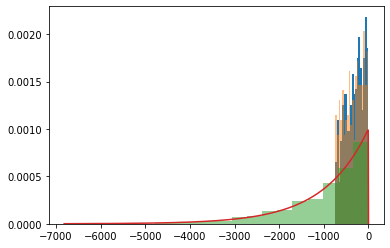

In [339]:
n = 1000
c = 1/1000
law = stats.loggamma(c)

# inverse transform samples
uu = np.random.rand(n)
samples = law.ppf(uu)
samples = samples[np.invert(np.isinf(samples))]
plt.hist(samples, bins=20, density=True)

# scipy sampling
samples2 = law.rvs(size=1000)
samples2 = samples2[np.invert(np.isinf(samples2))]
plt.hist(samples2, bins=20, density=True, alpha=.5)

# exponential sampling
samples3 = -stats.expon.rvs(scale=1/c, size=n)
plt.hist(samples3, bins=20, density=True, alpha=.5)

# density plot
xx = np.linspace(np.nanmin(samples3),2, 1000)
plt.plot(xx, law.pdf(xx))

print(len(samples), len(samples2), len(samples3))
pass